In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from json import load
from scipy.special import factorial
import scipy.io
import pandas as pd

# disable 'change sparsity is expensive' warnings 
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

# plt.style.use("bmh")

# useful reference for scipy sparse 

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.spmatrix.html#scipy.sparse.spmatrix

NOTATION:

$ \left|V\right| $ - Number of nodes

$ \left|E\right| $ - Number of edges 

$ \left|O\right| $ - Number of self-loops

$ \left\langle C\right\rangle $ - Average clustering coefficient 

$ \left\langle k\right\rangle $ - Average degree of a random node

$ \left\langle k_{k}\right\rangle $ - Average degree of the neighbours of a random node


# Real Networks

In [30]:
class network:
    
    def __init__(self, name, path):
        
        self.name = name
    
        if '.mat' in path:
            mat = scipy.io.loadmat(path)
            self.adj =  mat['Problem'][0][0][2]
            self.node_number = self.adj.shape[0]
            self.ki = np.array(self.adj.sum(axis = 1)).flatten().astype(int)
            self.ki_avg = self.ki.mean()
            self.get_cluster_coeff()
            self.get_friendship_paradox()
            
        else:
        
            if '.csv' in path:
                self.edges = np.genfromtxt(path, delimiter = ',', skip_header = 1).astype(int)
                self.node_number = np.max(self.edges) + 1

            elif 'facebook' in path:
                self.edges = np.genfromtxt(path, delimiter = ' ').astype(int)-1
                self.node_number = np.max(self.edges) + 1

            elif '.txt' in path:
                bad_edges = np.genfromtxt(path, delimiter = '\t', skip_header = 4).astype(int)

                elements = np.unique(bad_edges.flatten())

                conv_table = np.zeros(np.max(elements)+1).astype(int)
                for index, value in enumerate(elements):
                    conv_table[value] = index

                self.node_number = conv_table[-1] + 1

                self.edges = np.zeros(bad_edges.shape).astype(int)
                self.edges[:, 0] = conv_table[bad_edges[:, 0]]
                self.edges[:, 1] = conv_table[bad_edges[:, 1]]

            elif '.edges' in path:
                self.edges = np.genfromtxt(path, delimiter = ' ').astype(int)
                self.node_number = np.max(self.edges) + 1

            elif '.mtx' in path:
                self.edges = np.genfromtxt(path, delimiter = ' ', skip_header = 26).astype(int)-1
                self.node_number = np.max(self.edges) + 1

            else:
                print('File needs to be .csv or .txt')

            self.edges = np.unique(np.sort(self.edges, axis=1), axis = 0)        
            self.get_adj()
            self.ki = self.adj_np.sum(axis = 1)
            self.ki_avg = self.ki.mean()
            self.get_cluster_coeff()
            self.get_friendship_paradox()
        
# Determine adjacency matrix
       
    def get_adj(self):
        
        self.adj_np = np.zeros([self.node_number, self.node_number], dtype = int)
        
        self.adj_np[self.edges[:, 0], self.edges[:, 1]] = 1
        
        self.adj_np[self.edges[:, 1], self.edges[:, 0]] = 1
        
        self.adj = sparse.csr_matrix(self.adj_np)
        
# Determine tha average degree of the neighbours of a randomly chosen node

    def get_friendship_paradox(self):
        
        self.friend_paradox = self.adj.dot(self.ki) / self.ki
        
        self.friend_paradox = self.friend_paradox.sum() / self.node_number
        
# Determine clustering coefficient using the 3rd power of the adj matrix
    
    def get_cluster_coeff(self):

        adj_no_diag = self.adj.copy()
    
        adj_no_diag.setdiag(0)

        self.adj2  = adj_no_diag.dot( self.adj )

        self.adj3  = self.adj.dot( self.adj2 )
        
        self.C_arr = self.adj3.diagonal()
        
        mt1 = np.where(self.ki > 1)[0]
        
        new = self.C_arr[mt1] / ( self.ki[mt1] * (self.ki[mt1] - 1))
        
        self.C_avg = np.sum(new.sum()) / self.node_number
        
# Determine degree distribution

    def get_plots(self, poisson_fit = False):
        values, bins = np.histogram(self.ki, bins = np.arange(self.ki.min() - 0.5, self.ki.max() + 0.5, 1), density = True)
        bins = ((bins[:-1] + bins[1:])/2).astype(int)
        
        if poisson_fit:
            poisson = np.exp(-self.ki_avg) * np.power(self.ki_avg, self.ki) / factorial(self.ki)
        
        diag_sum = int(self.adj.diagonal().sum())
        edge_sum = int((self.adj.sum()-diag_sum)/2 + diag_sum)
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10, 5), constrained_layout=True)
        axs = axs.ravel()

        labels = [[r'Name', self.name],
                  [r'$ \left|V\right| $', self.node_number], 
                  [r'$ \left|E\right| $', edge_sum], 
                  [r'$ \left|O\right| $', diag_sum], 
                  [r'$ \left\langle C\right\rangle $', round(self.C_avg, 3)], 
                  [r'$ \left\langle k\right\rangle $', round(self.ki_avg, 3)], 
                  [r'$ \left\langle k_{k}\right\rangle $', round(self.friend_paradox, 3)]]

        axs[0].set_title('Adjacency Matrix')
        axs[0].imshow(self.adj.todense(), 'binary')
        
        axs[1].axis('off')
        table = axs[1].table(labels, colWidths = [0.1, 0.2], loc = 'center')
        table.auto_set_font_size(True)
        table.set_fontsize(20)
        table.scale(2, 2)
        
        plt.savefig('images/{}-A'.format(self.name))
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15, 5), constrained_layout=True)
        axs = axs.ravel()
        
        axs[0].plot(bins, values, 'k.')
        axs[0].set_title('Degree distribution of the network')
        axs[0].set_xlabel('$k$')
        axs[0].set_ylabel('$p_{k}$')
        
        if poisson_fit:
            axs[1].plot(self.ki, poisson, 'r.', label='poisson')
        
        axs[1].plot(bins, values, 'k.')
        axs[1].set_title('Degree distribution of the network log-log')
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')
        axs[1].set_xlabel(r'$k$')
        axs[1].set_ylabel(r'$ p_{k} $')
        axs[1].legend()

        plt.savefig('images/{}-B'.format(self.name))

/home/hugens/devel/env/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
No handles with labels found to put in legend.


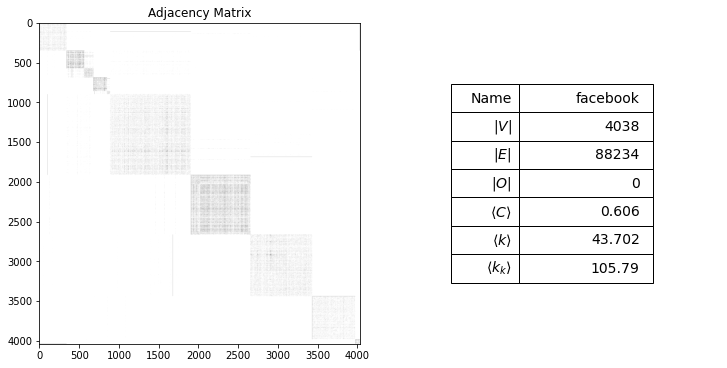

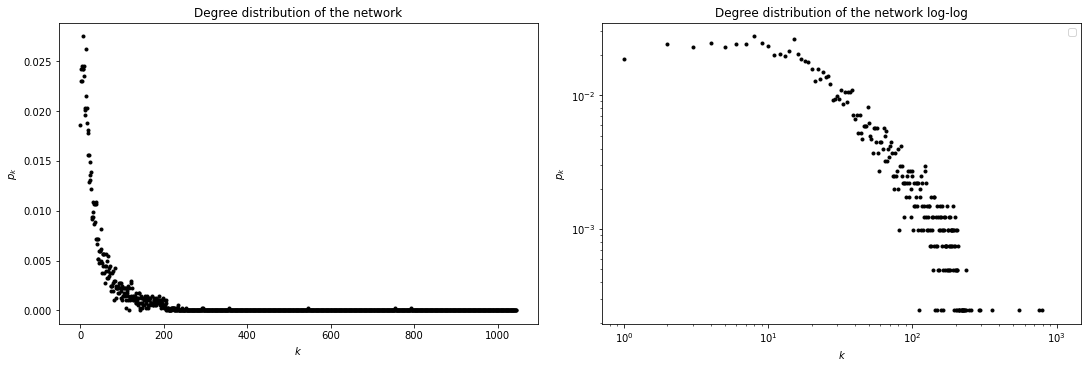

In [31]:
facebook = network('facebook', 'data/facebook/facebook.txt')
facebook.get_plots()

/home/hugens/devel/env/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


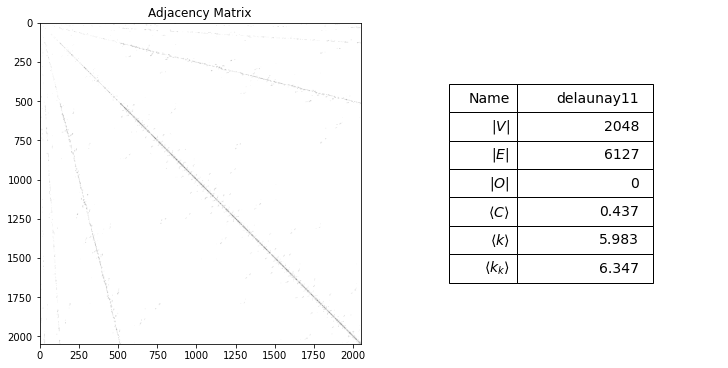

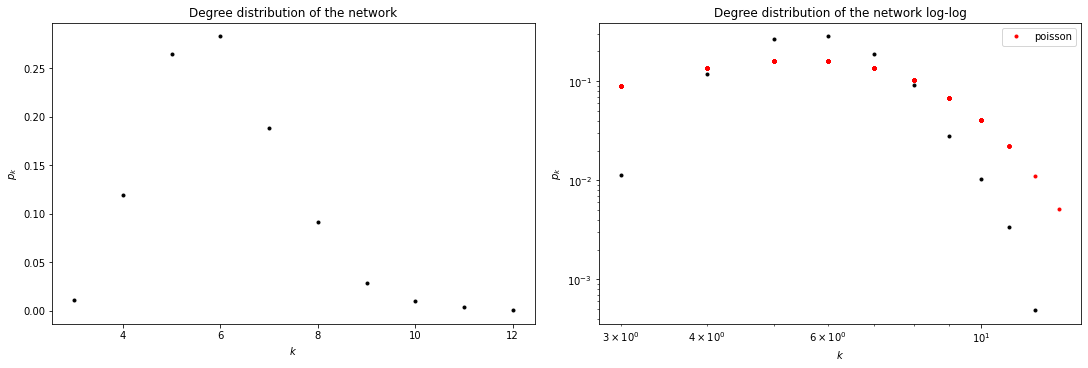

In [32]:
delaunay11 = network('delaunay11', 'data/delaunay/delaunay_n11.mat')
delaunay11.get_plots(poisson_fit=True)

In [6]:
# converting delaunay data to excel file
# a = np.zeros([int(delaunay11.adj.sum()),2]).astype(int)
# a[:, 0] = sparse.find(delaunay11.adj)[0]
# a[:, 1] = sparse.find(delaunay11.adj)[1]
# a = np.unique(np.sort(a, axis=1), axis = 0) 
# df = pd.DataFrame(a)
# df.to_excel('delaunay11.xlsx', index=False)

In [7]:
# delaunay14 = network('delaunay14', 'data/delaunay/delaunay_n14.mat')
# delaunay14.get_plots()

In [8]:
# power = network('power', 'data/power-US-Grid/power-US-Grid.mtx')
# power.get_plots()
# np.genfromtxt('data/power-US-Grid/power-US-Grid.mtx', delimiter = ' ', skip_header = 26).astype(int)

In [9]:
# bn_cat = network('bn', 'data/bn/bn-cat-mixed-species_brain_1.edges')
# bn_cat.get_plots()

In [10]:
# bn_fly = network('bn-fly', 'data/bn/bn-fly-drosophila_medulla_1.edges')
# bn_fly.get_plots()

In [11]:
# caGr = network('caG', 'data/ca-GrQc/ca-GrQc.txt')
# caGr.get_plots()
# Nodes	5242
# Edges	14496
# Nodes in largest WCC	4158 (0.793)
# Edges in largest WCC	13428 (0.926)
# Nodes in largest SCC	4158 (0.793)
# Edges in largest SCC	13428 (0.926)
# Average clustering coefficient	0.5296
# Number of triangles	48260
# Fraction of closed triangles	0.3619
# Diameter (longest shortest path)	17
# 90-percentile effective diameter	7.6

In [12]:
# fm = network('LastFM', 'data/lasftm_asia/lastfm_asia_edges.csv')
# fm.get_plots()

In [13]:
# caHE = network('caHE', 'data/ca-HepTh/ca-HepTh.txt')
# caHE.get_plots()
# Nodes	9877
# Edges	25998
# Nodes in largest WCC	8638 (0.875)
# Edges in largest WCC	24827 (0.955)
# Nodes in largest SCC	8638 (0.875)
# Edges in largest SCC	24827 (0.955)
# Average clustering coefficient	0.4714
# Number of triangles	28339
# Fraction of closed triangles	0.1168
# Diameter (longest shortest path)	17
# 90-percentile effective diameter	7.4

In [14]:
# croc = network('crocodile', 'data/wikipedia/crocodile/musae_crocodile_edges.csv')
# croc.get_plots()

In [15]:
# cham = network('chameleon', 'data/wikipedia/chameleon/musae_chameleon_edges.csv')
# cham.get_plots()

In [16]:
# squir = network('squirrel', 'data/wikipedia/squirrel/musae_squirrel_edges.csv')
# squir.get_plots()